# Check THE GPU Status

In [1]:
!nvidia-smi

Fri Aug 12 16:22:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Downloading the Dataset

In [2]:
#!wget https://www.dropbox.com/s/fxn3ldztzwxm0rw/FruitsData.zip

In [3]:
!pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"danafatadillarabba","key":"83d806b564a918c17af31cb210c54538"}'}

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

## Dataset Properties

- Fruits 360 dataset: A dataset of images containing fruits and vegetables
- Version: 2020.05.18.0
- The total number of images: 90483.

- Training set size: 67692 images (one fruit or vegetable per image).

- Test set size: 22688 images (one fruit or vegetable per image).

- The number of classes: 131 (fruits and vegetables).

- Image size: 100x100 pixels.

In [7]:
!kaggle datasets download -d moltean/fruits

100% 1.28G/1.28G [00:07<00:00, 198MB/s]
100% 1.28G/1.28G [00:07<00:00, 181MB/s]


In [8]:
!unzip -q "/content/fruits.zip"

# Importing the necessary libraries

In [9]:
# Imports required for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [10]:
# Creating the Pathlib PATH objects
train_path = Path("//content/fruits-360_dataset/fruits-360/Training")
test_path = Path("/content/fruits-360_dataset/fruits-360/Test")

In [11]:
# Collecting all the Paths Inside the folders of the above paths
train_image_paths = train_path.glob("*/*")
test_image_paths = test_path.glob("*/*")

# Output is a Generator object
print(train_image_paths)

<generator object Path.glob at 0x7f4445aea150>


# Data Processing

In [12]:
# Getting Image paths 
train_image_paths = list(map(lambda x : str(x) , train_image_paths))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))

train_image_paths[:10]

['//content/fruits-360_dataset/fruits-360/Training/Grape White 3/r_309_100.jpg',
 '//content/fruits-360_dataset/fruits-360/Training/Grape White 3/r_48_100.jpg',
 '//content/fruits-360_dataset/fruits-360/Training/Grape White 3/r_62_100.jpg',
 '//content/fruits-360_dataset/fruits-360/Training/Grape White 3/32_100.jpg',
 '//content/fruits-360_dataset/fruits-360/Training/Grape White 3/r_36_100.jpg',
 '//content/fruits-360_dataset/fruits-360/Training/Grape White 3/r_298_100.jpg',
 '//content/fruits-360_dataset/fruits-360/Training/Grape White 3/237_100.jpg',
 '//content/fruits-360_dataset/fruits-360/Training/Grape White 3/171_100.jpg',
 '//content/fruits-360_dataset/fruits-360/Training/Grape White 3/27_100.jpg',
 '//content/fruits-360_dataset/fruits-360/Training/Grape White 3/r_287_100.jpg']

In [13]:
# Collect Length for Training and Validation Datasets
train_dataset_length = len(train_image_paths)
test_dataset_length = len(test_image_paths)

print("Number of train image: ", train_dataset_length)
print("Number of testing image: ", test_dataset_length)

Number of train image:  67692
Number of testing image:  22688


**Labelling the Data**

In [14]:
# Getting their respective labels 

def get_label(image_path):
    return image_path.split("/")[-2]

train_image_labels = list(map(lambda x : get_label(x) , train_image_paths))
test_image_labels = list(map(lambda x : get_label(x) , test_image_paths))

train_image_labels[:10]

['Grape White 3',
 'Grape White 3',
 'Grape White 3',
 'Grape White 3',
 'Grape White 3',
 'Grape White 3',
 'Grape White 3',
 'Grape White 3',
 'Grape White 3',
 'Grape White 3']

In [15]:
from sklearn.preprocessing import LabelEncoder 

Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)
test_image_labels = Le.fit_transform(test_image_labels)

train_image_labels[:10]

array([48, 48, 48, 48, 48, 48, 48, 48, 48, 48])

In [16]:
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)
test_image_labels = tf.keras.utils.to_categorical(test_image_labels)


train_image_labels[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
from sklearn.model_selection import train_test_split 

train_images, val_images, train_labels, val_labels = train_test_split(train_image_paths , train_image_labels, test_size=0.2, random_state=42)

In [18]:
# Function used for Transformation

def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

In [19]:
# Define IMAGE SIZE and BATCH SIZE 
IMG_SIZE = 224 
BATCH_SIZE = 32

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)          
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.3, -0.2))
])

In [20]:
# Function used to Create a Tensorflow Data Object
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.repeat()
    return dataset

**Previewing the images of train and validation dataset**





In [21]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(train_images, train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 635 ms, sys: 40.1 ms, total: 675 ms
Wall time: 818 ms
(32, 224, 224, 3)
(32, 131)


Cantaloupe 2


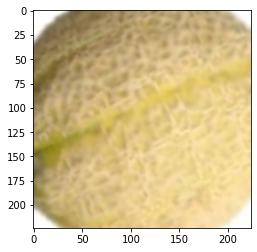

In [22]:
# View a sample Training Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(224 , 224 , 3))

In [23]:
%time val_dataset = get_dataset(val_images, val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 37.2 ms, sys: 882 µs, total: 38.1 ms
Wall time: 40.3 ms
(32, 224, 224, 3)
(32, 131)


Physalis with Husk


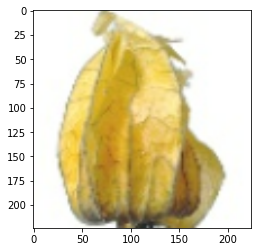

In [24]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(224 , 224 , 3))

# Training the Model

**Train the model first time**

In [25]:
# Building InceptionV3 model
from tensorflow.keras.applications.inception_v3 import InceptionV3

backbone = InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(131, activation='softmax')
])

model.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 131)               268419    
                                                                 
Total params: 22,071,203
Trainable params: 22,036,771
Non-trainable params: 34,432
_________________________________________________________________


In [26]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [27]:
# Defining our callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [28]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch= len(train_images)//BATCH_SIZE,
    epochs=1,
    #callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(val_images)//BATCH_SIZE
)

1692/1692 [==============================] - 622s 354ms/step - loss: 0.5416 - accuracy: 0.8493 - precision: 0.9190 - recall: 0.8026 - val_loss: 0.9697 - val_accuracy: 0.7384 - val_precision: 0.7780 - val_recall: 0.7023


** Train the model second time (without the first layer (ResNet Model)**

In [29]:
model.layers[0].trainable = False

In [30]:
# Defining our callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 131)               268419    
                                                                 
Total params: 22,071,203
Trainable params: 268,419
Non-trainable params: 21,802,784
_________________________________________________________________


In [32]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=  len(train_images)//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(val_images)//BATCH_SIZE,
)

Epoch 1/8
1692/1692 [==============================] - ETA: 0s - loss: 0.1128 - accuracy: 0.9661 - precision: 0.9713 - recall: 0.9610
Epoch 1: val_loss improved from inf to 1.76593, saving model to best_weights.h5
1692/1692 [==============================] - 586s 346ms/step - loss: 0.1128 - accuracy: 0.9661 - precision: 0.9713 - recall: 0.9610 - val_loss: 1.7659 - val_accuracy: 0.6430 - val_precision: 0.6673 - val_recall: 0.6226
Epoch 2/8
1692/1692 [==============================] - ETA: 0s - loss: 0.0903 - accuracy: 0.9724 - precision: 0.9759 - recall: 0.9695
Epoch 2: val_loss improved from 1.76593 to 1.42104, saving model to best_weights.h5
1692/1692 [==============================] - 586s 345ms/step - loss: 0.0903 - accuracy: 0.9724 - precision: 0.9759 - recall: 0.9695 - val_loss: 1.4210 - val_accuracy: 0.6767 - val_precision: 0.7185 - val_recall: 0.6452
Epoch 3/8
1692/1692 [==============================] - ETA: 0s - loss: 0.0669 - accuracy: 0.9809 - precision: 0.9832 - recall: 0.9

#Result of the Model

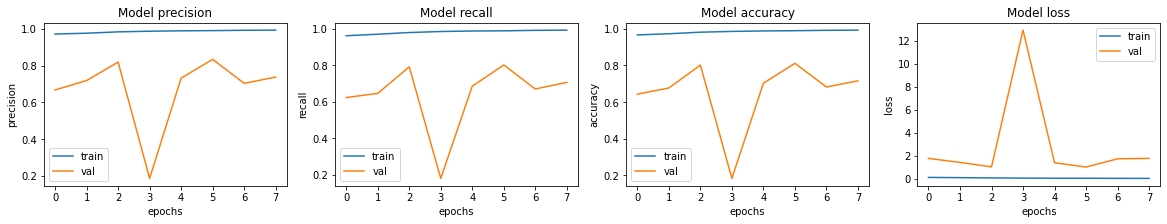

In [33]:
# Interpreting the Metrics 
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#Saving and Testing the Model

In [34]:
# Save the whole model (weigths + architecture)
model.save("model.h5")

In [35]:
# Loading the whole model
loaded_model = tf.keras.models.load_model("model.h5")

In [36]:
def get_test_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
    
    return dataset

In [37]:
%time test_dataset = get_test_dataset(test_image_paths, test_image_labels , train = False)

image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

CPU times: user 57.6 ms, sys: 1.01 ms, total: 58.6 ms
Wall time: 57.9 ms
(32, 224, 224, 3)
(32, 131)


Apple Red Yellow 2


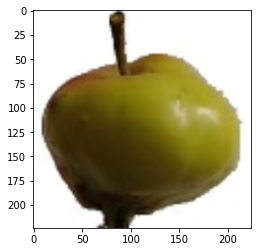

In [38]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(224 , 224 , 3))

In [39]:
# Evaluating the loaded model
loss, acc, prec, rec = loaded_model.evaluate(test_dataset)

print(" Testing Loss " , loss)
print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

709/709 [==============================] - 72s 99ms/step - loss: 2.2646 - accuracy: 0.6658 - precision: 0.6927 - recall: 0.6511
 Testing Loss  2.264587879180908
 Testing Acc :  0.6657704710960388
 Testing Precision  0.6926575303077698
 Testing Recall  0.6511371731758118
